In [1]:
!pip install transformers

In [2]:
#for reproducability
SEED = 34

#maximum number of words in output text
MAX_LEN = 70

In [3]:
input_sequence = "i have an apple"

##這裡將選擇最大的 gpt2-large 模型

In [4]:
#get transformers
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer

#get large GPT2 tokenizer and GPT2 model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-large")
GPT2 = TFGPT2LMHeadModel.from_pretrained("gpt2-large", pad_token_id=tokenizer.eos_token_id)

#tokenizer = GPT2Tokenizer.from_pretrained("gpt2-medium")
#GPT2 = TFGPT2LMHeadModel.from_pretrained("gpt2-medium", pad_token_id=tokenizer.eos_token_id)

#tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
#GPT2 = TFGPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

#view model parameters
GPT2.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLay  multiple                  774030080 
 er)                                                             
                                                                 
Total params: 774030080 (2.88 GB)
Trainable params: 774030080 (2.88 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#不同的解碼方法
##貪婪搜尋法(Greedy Search)
透過貪婪搜索，機率最高的單字被預測為下一個單字

In [5]:
#get deep learning basics
import tensorflow as tf
tf.random.set_seed(SEED)

# encode context the generation is conditioned on
input_ids = tokenizer.encode(input_sequence, return_tensors='tf')

# generate text until the output length (which includes the context length) reaches 50
greedy_output = GPT2.generate(input_ids, max_length = MAX_LEN)

print("Output:\n")
print(tokenizer.decode(greedy_output[0], skip_special_tokens = True))

Output:

i have an apple pie, and I'm not sure if I'm going to be able to eat it.

I'm not sure if I'm going to be able to eat it.

I'm not sure if I'm going to be able to eat it.

I'm not sure if I'm going to be able to


可以發現模型很快就開始說一些重複的話。貪婪搜尋的主要問題是，高機率的詞可能會被前面出現的低機率的詞所覆蓋，這樣模型就無法嘗試更多種不同的詞組合。

與貪婪搜尋相比，Beam search 試圖去生成更加多樣化且適合上下文的文字。 如果我們增加 num_beams，那麼我們會在不同的 beams 中看到更多的變化。

此外，研究表明人類語言並不常選擇這種「高機率下一個單字」的分佈。

##Beam Search with N-Gram Penalities

Beam Search是一種生成文本的方法，類似於貪婪搜索，但有些不同。它會在每個時間步追蹤多個可能的選擇，稱為束（beam），數量由num_beams決定。這樣可以比較多條生成路徑，幫助模型找到更好的結果。可以透過設置no_repeat_ngram_size = 2來使用N-Gram Penalty，確保不會出現重複的2個詞組。另外，設置num_return_sequences = 5 可以讓我們查看其他5個可能的生成結果。

In [ ]:
# set return_num_sequences > 1
beam_outputs = GPT2.generate(
    input_ids,
    max_length = MAX_LEN,
    num_beams = 5,
    no_repeat_ngram_size = 2,
    num_return_sequences = 5,
    early_stopping = True
)

# now we have 3 output sequences
for i, beam_output in enumerate(beam_outputs):
      print("{}: {}\n".format(i, tokenizer.decode(beam_output, skip_special_tokens=True)))

0: i have an apple tree in their backyard.

"I think it's a good idea," he said. "I don't know if it will work, but it would be nice to have something like that."

1: i have an apple tree in their backyard.

"I think it's a good idea," he said. "I don't know if it will work, but it would be nice to have a tree like that."

2: i have an apple tree in their backyard.

"I think it's a good idea," he said. "I don't know if it will work, but it would be nice to have it."

3: i have an apple tree in their backyard.

"I think it's a good idea," he said. "I don't know if it will work, but we'll see."

4: i have an apple tree in their backyard.

"I think it's a good idea," he said. "I don't know if it will work, but it would be nice."



這五種不同的beam假設幾乎都是相同的，但如果我們增加 num_beams ，我們會在各個獨立beam中看到更多的變化。當然，Beam search 也有其限制。當生成的文本長度固定時（如翻譯或摘要），其效果非常好，但對於開放式問題，如對話或故事生成，效果則不盡理想。

##Base Sample
通過條件機率分布隨機選擇下一個單詞：

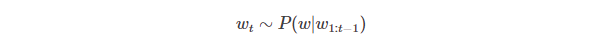

當我們引入這種隨機性時，生成的文本往往顯得不連貫。因此，我們可以引入temperature參數，增加高機率單詞的選擇機會，同時減少低機率單詞的選擇機會

只需將do_sample設置為True即可實現採樣

In [ ]:
# use temperature to decrease the sensitivity to low probability candidates
sample_output = GPT2.generate(
    input_ids,
    do_sample = True,
    max_length = MAX_LEN,
    top_k = 0,
    temperature = 0.8
)

print(tokenizer.decode(sample_output[0], skip_special_tokens = True))

i have an apple orchard in the village, which is the main source of income.

"I came to Alexandria to marry my sister, but after we got married, I would lose 30, 40 percent of my income," admitted the woman, who asked not to be named.

"The government does not provide us with enough food


##Top-K Sampling
在「Top-K 抽樣」中，我們會從最有可能的幾個單詞中選擇下一個，而不是增加高機率單詞的出現機會或降低低機率單詞的出現機會。相反，我們直接忽略那些機率很低的單詞。

我們只需要將 top_k 設置為我們想要考慮的前 k 個單詞數量即可構建條件機率分佈。

In [ ]:
#sample from only top_k most likely words
sample_output = GPT2.generate(
    input_ids,
    do_sample = True,
    max_length = MAX_LEN,
    top_k = 50
)

print(tokenizer.decode(sample_output[0], skip_special_tokens = True))

i have an apple or two in the fridge, along with a couple of large olives, as I have a special craving for that sweet, juicy, juicy sauce. I can easily do both the olives and the pecans this way and still have just as many items in my fridge.

Another way to double this is to take


用「Top-K 抽樣」產生的文本比我們之前的隨機抽樣更連貫。但還可以更進一步。

##Top-P Sampling
Top-P 抽樣（也被稱為 nucleus 抽樣）與 Top-K 抽樣類似，但不是選擇最可能的前 k 個單詞，Top-P 抽樣就像是在一群單詞中挑選最有可能的，但不是挑固定數量，而是挑到總機率超過一定閾值 p 為止。所以，我們會調整抽樣的範圍，以確保挑出的單詞機率總和超過 p。這樣做的好處是可以根據不同情况調整抽樣的數量，讓模型有更多的選擇。

In [ ]:
#sample only from 80% most likely words
sample_output = GPT2.generate(
    input_ids,
    do_sample = True,
    max_length = MAX_LEN,
    top_p = 0.8,
    top_k = 0
)

print(tokenizer.decode(sample_output[0], skip_special_tokens = True))

i have an apple or a pear? What color is that?" When we were there I got a pear and had to go back to the store to get a fruit that wasn't even on the tree. My first week was pretty terrible.

Can you name all of the dangers and illness you've ever experienced?

Nuclear bomb!


##Top-K and Top-P Sampling
這裡可以同時使用 Top-K 和 Top-P 抽樣。這樣可以減少我們獲得奇怪單詞（低概率單詞）的機會，同時允許動態選擇大小。我們只需要為 top_k 和 top_p 各指定一個值。如果需要，我們甚至可以包含初始temperature參數。

In [ ]:
#combine both sampling techniques
sample_outputs = GPT2.generate(
input_ids,
  do_sample = True,
  max_length = 2*MAX_LEN,
  top_k = 50,
  top_p = 0.85,
  num_return_sequences = 5
)

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n".format(i, tokenizer.decode(sample_output, skip_special_tokens = True)))

0: i have an apple pie from the French New York Deli. I thought that was pretty funny because they are all from the state of New York. I'll tell you what's funnier, they have one of the most famous pie recipes in the world, I'll give you that. They have a recipe for the classic French New York Pie, and it's basically just a giant, deep dish, that's got this sweet filling. It's the most famous pie in the world, it's a classic, and that's what I like, I don't care where the cheese comes from, that's the part that I like, the cheese. But the rest of it is just a pie

1: i have an apple-shaped hole in the middle of the nose, like the apple does when you chew it, but they can also be rectangular or round.

This is the only type of apple that contains the seeds of the other fruits of the family. If you eat apples you can't get cancer.

Seed

The seed of the apple is yellow-orange. The seeds of the other apples can be red, green, or purple.

Pronunciation

English

a apple a apple

Yiddish

a

##Benchmark Prompts
在這裡，將看到當提供一些更有趣的輸入時，GPT-2 模型的表現如何



#Can we use GPT-2 to generate fake news stories?


In [ ]:
MAX_LEN = 150

prompt1 = 'In 2024, scientists discovered a microorganism that can completely remove plastic pollution, bringing new hope to the earth\'s environment.'

input_ids = tokenizer.encode(prompt1, return_tensors='tf')

In [ ]:
sample_outputs = GPT2.generate(
    input_ids,
    do_sample = True,
    max_length = MAX_LEN,
    #temperature = .8,
    top_k = 50,
    top_p = 0.85
    #num_return_sequences = 5
)

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens = True)))
    print('')

0: In 2024, scientists discovered a microorganism that can completely remove plastic pollution, bringing new hope to the earth's environment. It could be used in the creation of new, environmentally friendly plastics, which are used in everything from clothing to food and toys.

This story is still developing. Stay tuned to The Daily Sheeple for more updates!

This article (Scientists Discover a Microorganism That Can Remove Plastic Pollution, Creating New Plastic Products) is free and open source. You have permission to republish this article under a Creative Commons license with attribution to the author and TrueActivist.com



#Can we use GPT-2 to do our homework? (not ours)

In [ ]:
prompt3 = 'For today’s assignment, please describe the reasons that triggered the Russo-Ukrainian war.'

input_ids = tokenizer.encode(prompt3, return_tensors='tf')

In [ ]:
sample_outputs = GPT2.generate(
    input_ids,
    do_sample = True,
    max_length = MAX_LEN,
    #temperature = .8,
    top_k = 50,
    top_p = 0.85
    #num_return_sequences = 5
)

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens = True)))
    print('')

0: For today’s assignment, please describe the reasons that triggered the Russo-Ukrainian war. I want to get a sense of what motivated Putin and the Kremlin.

As a first step, please describe how you think Putin's war in Ukraine has served Russian interests.

What I've observed about Russia's policies in Ukraine has been a consistent focus on Russia's own security. Russian leaders have been particularly concerned about the rise of the so-called "Eurasian Union" (also known as the Eurasian Economic Union). Russia's leaders have been trying to undermine the EU by pushing the country towards becoming a more independent economic zone within the EU.

Putin also sees Ukraine as a strategic prize, and is concerned about



In [ ]:
prompt4 = 'Fast and Furious is a'

input_ids = tokenizer.encode(prompt4, return_tensors='tf')

In [ ]:
sample_outputs = GPT2.generate(
    input_ids,
    do_sample = True,
    max_length = MAX_LEN,
    #temperature = .8,
    top_k = 50,
    top_p = 0.85
    #num_return_sequences = 5
)

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens = True)))
    print('')

0: Fast and Furious is a major financial success, generating nearly $500 million in ticket sales to date, and grossing $400 million worldwide to date. This film may not be as big as "Fast and Furious," but it is still a tremendous success.

"Fast and Furious" has also proven that the biggest franchise is still the most profitable.

